# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV116"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv116')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv116/lv116-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 11:44:27,149 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
505,IRIS_DendriticCell-LPSstimulated,116,0.645137,9.919094e-05,1.094389e-03
506,SVM Macrophages M1,116,0.922351,1.151361e-06,2.086963e-05
507,REACTOME_NEGATIVE_REGULATORS_OF_RIG_I_MDA5_SIG...,116,0.805977,2.594296e-03,1.608016e-02
508,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,116,0.670073,1.046582e-05,1.525323e-04
509,KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY,116,0.842774,3.599076e-04,3.224361e-03
510,REACTOME_INTERFERON_SIGNALING,116,0.842482,8.398377e-11,3.483711e-09
511,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,116,0.937090,1.995367e-06,3.362506e-05


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

In [19]:
lv_data.shape

(4274, 105)

In [20]:
lv_data.head()

age     group organisms  severity  \
project   run                                                             
SRP059039 SRR2049587  2 year-old or older   Control      EPEC   Control   
          SRR2049621  2 year-old or older  Diarrhea      DAEC      mild   
          SRR2049622  2 year-old or older  Diarrhea      DAEC      mild   
          SRR2049620          <2 year-old  Diarrhea      DAEC  moderate   
          SRR2049619          <2 year-old  Diarrhea      DAEC      mild   

                           tissue flowcell lane cellcount celltype  \
project   run                                                        
SRP059039 SRR2049587  Whole blood        A    8       NaN      NaN   
          SRR2049621  Whole blood        A    6       NaN      NaN   
          SRR2049622  Whole blood        A    7       NaN      NaN   
          SRR2049620  Whole blood        A    6       NaN      NaN   
          SRR2049619  Whole blood        A    5       NaN      NaN   

                     collectiondate  ... sample group pre- or post-challenge  \
project   run                        ...                                       
SRP059039 SRR2049587            NaN  ...          NaN                    NaN   
          SRR2049621            NaN  ...          NaN                    NaN   
          SRR2049622            NaN  ...          NaN                    NaN   
          SRR2049620            NaN  ...          NaN                    NaN   
          SRR2049619            NaN  ...          NaN                    NaN   

                     passage protocol location knockdown chemistry  \
project   run                                                        
SRP059039 SRR2049587     NaN      NaN      NaN                 NaN   
          SRR2049621     NaN      NaN      NaN                 NaN   
          SRR2049622     NaN      NaN      NaN                 NaN   
          SRR2049620     NaN      NaN      NaN                 NaN   
          SRR2049619     NaN      NaN      NaN                 NaN   

                     knockdown target genotype/variation rna type     LV116  
project   run                                                                
SRP059039 SRR2049587              NaN                NaN      NaN  0.004389  
          SRR2049621              NaN                NaN      NaN  0.083800  
          SRR2049622              NaN                NaN      NaN  0.302118  
          SRR2049620              NaN                NaN      NaN  0.514293  
          SRR2049619              NaN                NaN      NaN -0.004081  

[5 rows x 105 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

subject #                         0.910696
ad type                           0.910696
disease model                     0.561202
donor identifier                  0.556167
status                            0.403333
donor id                          0.356871
treatment                         0.331421
organisms                         0.297879
severity                          0.297879
lane                              0.297879
flowcell                          0.297879
age                               0.215637
group                             0.166657
transfection                      0.098785
tissue                            0.097682
transfected with                  0.096817
time since symptom onset (yrs)    0.096609
cellcount                         0.096609
samplename                        0.096609
donorid                           0.096609
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue          0.097682
cell type       0.056706
cell subtype    0.035469
tissue type     0.017317
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "tissue",
        "cell type",
        "cell subtype",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

tissue                     cell type cell subtype  \
project   run                                                                  
SRP045500 SRR1551101          NaN                           NaN          NaN   
SRP045569 SRR1552922          NaN                         PBMCs          NaN   
SRP015670 SRR566224           NaN  monocyte-derived macrophages          NaN   
          SRR566255           NaN  monocyte-derived macrophages          NaN   
SRP059039 SRR2049711  Whole blood                           NaN          NaN   
          SRR2049695  Whole blood                           NaN          NaN   
SRP045569 SRR1552919          NaN                         PBMCs          NaN   
SRP015670 SRR566256           NaN  monocyte-derived macrophages          NaN   
          SRR566259           NaN  monocyte-derived macrophages          NaN   
          SRR566260           NaN  monocyte-derived macrophages          NaN   
SRP045569 SRR1552918          NaN                         PBMCs          NaN   
SRP059039 SRR2049693  Whole blood                           NaN          NaN   
SRP063059 SRR2225768          NaN             dermal fibroblast          NaN   
SRP059039 SRR2049685  Whole blood                           NaN          NaN   
SRP059531 SRR2064026          NaN           Primary fibroblasts          NaN   
SRP059039 SRR2049647  Whole blood                           NaN          NaN   
SRP015670 SRR566239           NaN  monocyte-derived macrophages          NaN   
SRP059039 SRR2049697  Whole blood                           NaN          NaN   
SRP015670 SRR566231           NaN  monocyte-derived macrophages          NaN   
          SRR566243           NaN  monocyte-derived macrophages          NaN   
          SRR566235           NaN  monocyte-derived macrophages          NaN   
SRP063059 SRR2225773          NaN             dermal fibroblast          NaN   
          SRR2225759          NaN             dermal fibroblast          NaN   
          SRR2225767          NaN             dermal fibroblast          NaN   
          SRR2225761          NaN             dermal fibroblast          NaN   

                     tissue type     LV116  
project   run                               
SRP045500 SRR1551101         NaN  1.651573  
SRP045569 SRR1552922         NaN  1.649969  
SRP015670 SRR566224          NaN  1.612434  
          SRR566255          NaN  1.600180  
SRP059039 SRR2049711         NaN  1.573380  
          SRR2049695         NaN  1.569120  
SRP045569 SRR1552919         NaN  1.550139  
SRP015670 SRR566256          NaN  1.539199  
          SRR566259          NaN  1.504909  
          SRR566260          NaN  1.449393  
SRP045569 SRR1552918         NaN  1.446892  
SRP059039 SRR2049693         NaN  1.419280  
SRP063059 SRR2225768         NaN  1.418695  
SRP059039 SRR2049685         NaN  1.387894  
SRP059531 SRR2064026         NaN  1.383842  
SRP059039 SRR2049647         NaN  1.379851  
SRP015670 SRR566239          NaN  1.303341  
SRP059039 SRR2049697         NaN  1.279200  
SRP015670 SRR566231          NaN  1.273167  
          SRR566243          NaN  1.234809  
          SRR566235          NaN  1.224483  
SRP063059 SRR2225773         NaN  1.223209  
          SRR2225759         NaN  1.219530  
          SRR2225767         NaN  1.215482  
          SRR2225761         NaN  1.204726

In [26]:
SELECTED_ATTRIBUTE = "tissue"

In [27]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["cell type", "celltype", "agent"]

## Get plot data

In [28]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [29]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [30]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [31]:
plot_data.head(20)

tissue     LV116
project   run                                    
SRP059039 SRR2049707        Whole blood  2.780800
          SRR2049762        Whole blood  2.343260
          SRR2049689        Whole blood  2.334816
          SRR2049670        Whole blood  2.324611
SRP045500 SRR1551040        Neutrophils  2.307126
SRP059039 SRR2049714        Whole blood  2.213722
SRP063059 SRR2225771  dermal fibroblast  2.151321
SRP059039 SRR2049679        Whole blood  2.096461
          SRR2049683        Whole blood  2.082952
SRP045569 SRR1552931              PBMCs  2.047151
          SRR1552921              PBMCs  2.039088
          SRR1552933              PBMCs  2.031884
          SRR1552930              PBMCs  1.994696
SRP059039 SRR2049702        Whole blood  1.983245
          SRR2049672        Whole blood  1.917131
SRP045569 SRR1552920              PBMCs  1.908284
          SRR1552932              PBMCs  1.902258
SRP059039 SRR2049610        Whole blood  1.889801
SRP045569 SRR1552929              PBMCs  1.864157
SRP063059 SRR2225769  dermal fibroblast  1.797397

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [32]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "whole blood": "Whole blood",
            "PBMCs": "Peripheral blood mononuclear cells",
            "monocyte-derived macrophages": "Monocyte-derived macrophages",
            "peripheral blood monocytes": "Monocytes",
            "dermal fibroblast": "Dermal fibroblasts",
            "proximal tubular epithelial cells": "Proximal tubular epithelial cells",
            "glioblastoma cell line": "Glioblastoma cell line",
        }
    }
)

In [33]:
_srp_code = "SRP048804"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'cell line']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

_srp_code = "SRP045352"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "Monocytes" + f" ({lv_data.loc[(_srp_code, x.name), 'agent']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP056733"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "Macrophages" + f" ({lv_data.loc[(_srp_code, x.name), 'agent']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

_srp_code = "SRP062958"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'treatment']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

# # add also tissue information to these projects
_srp_code = "SRP015670"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'treatment']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

# # add also tissue information to these projects
_srp_code = "SRP045500"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'diseasestatus']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

# # add also tissue information to these projects
_srp_code = "SRP045569"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'treatment']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


# # add also tissue information to these projects
_srp_code = "SRP062966"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'ism']} SLE)",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


# # add also tissue information to these projects
_srp_code = "SRP059039"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'group']} cases)",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


# # add also tissue information to these projects
_srp_code = "SRP060370"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'treatment']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-33-be24e4f8a904>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-33-be24e4f8a904>:52: PerformanceWarnin

In [34]:
final_plot_data = final_plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "\(interferon-alpha\)": "(IFNa)",
            "\(HSV-1\)": "(HSV)",
            "\(West Nile virus \(WNV\)\)": "(WNV)",
            "\(ISM_high SLE\)": "(ISM high SLE)",
        }
    },
    regex=True,
)

## Threshold LV values

In [35]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [36]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [37]:
N_TOP_ATTRS = 15

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

15

In [40]:
attr_order[:5]

['Whole blood (Diarrhea cases)',
 'Neutrophils (MS posttreatment)',
 'Dermal fibroblasts',
 'Peripheral blood mononuclear cells (HSV)',
 'Monocyte-derived macrophages (WNV)']

## Plot

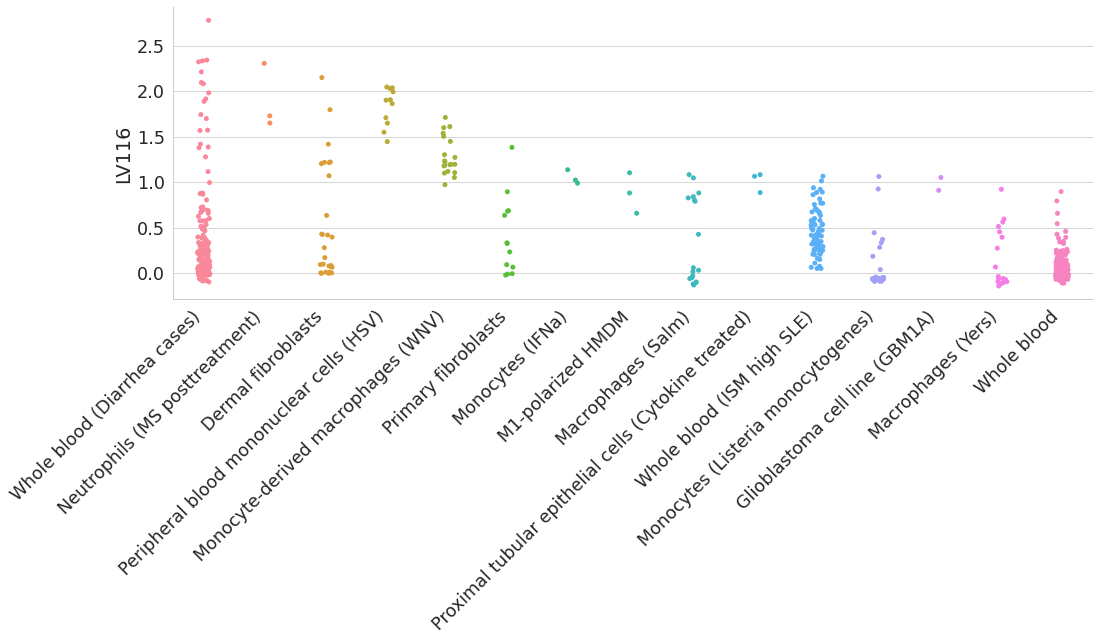

In [41]:
with sns.plotting_context("paper", font_scale=2.0), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("Salm")]
#     display(_tmp)

In [43]:
# # what is there in these projects?
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = (
#         lv_data.loc[["SRP063059"]]
#         .dropna(how="all", axis=1)
#         .sort_values(LV_NAME, ascending=False)
#     )
#     display(_tmp)